In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd

from ipykernel import kernelapp as app
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import rasterio as rio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm

# Machine learning
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

In [2]:
date_first_start = '2019-04-18'
date_first_end = '2019-04-20'

date_last_start = '2019-08-21'
date_last_end = '2019-08-22'

first_time_interval = [date_first_start, date_first_end]
last_time_interval = [date_last_start, date_last_end]

# Target CRS of border file
#target_CRS = CRS.UTM_35M

# border file
country_file = 'place.geojson'

# land cover file
land_cover_file = 'exampe_repr.shp'

# Folder where data for running the notebook is stored
# Folder with border file
DATA_FOLDER = ('C:/Users/frolui/Documents/GitHub/using-eo-learn-in-remote-sensing-/diplom_project')

use_smaller_patches = True

Dimension of the area is 14410 x 15443 m2


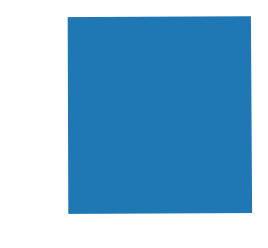

In [3]:
# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, country_file))

# Convert CRS to UTM_35N
country_crs = CRS.UTM_35N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

In [4]:
# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (2, 2))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (2 * 3, 2 * 3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 15 if use_smaller_patches else 190

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)
        
# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y},
                       crs={'init': CRS.ogc_string(country_crs)},
                       geometry=geometry)

# save to shapefile
shapefile_name = './selected_3x3_bboxes_small.shp' if use_smaller_patches \
    else './selected_3x3_bboxes_large.shp'
gdf.to_file(shapefile_name)        

In [5]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()

,index_x,index_y,geometry
0,1,4,"POLYGON ((518913.6757253294 5727228.931828612,..."
1,2,4,"POLYGON ((521315.3085657184 5727228.931828612,..."
2,3,4,"POLYGON ((523716.9414061075 5727228.931828612,..."
3,1,3,"POLYGON ((518913.6757253294 5724655.036680756,..."
4,2,3,"POLYGON ((521315.3085657184 5724655.036680756,..."


(515791.5530328235, 531642.3297793912, 5716161.1826928295, 5733148.890668681)

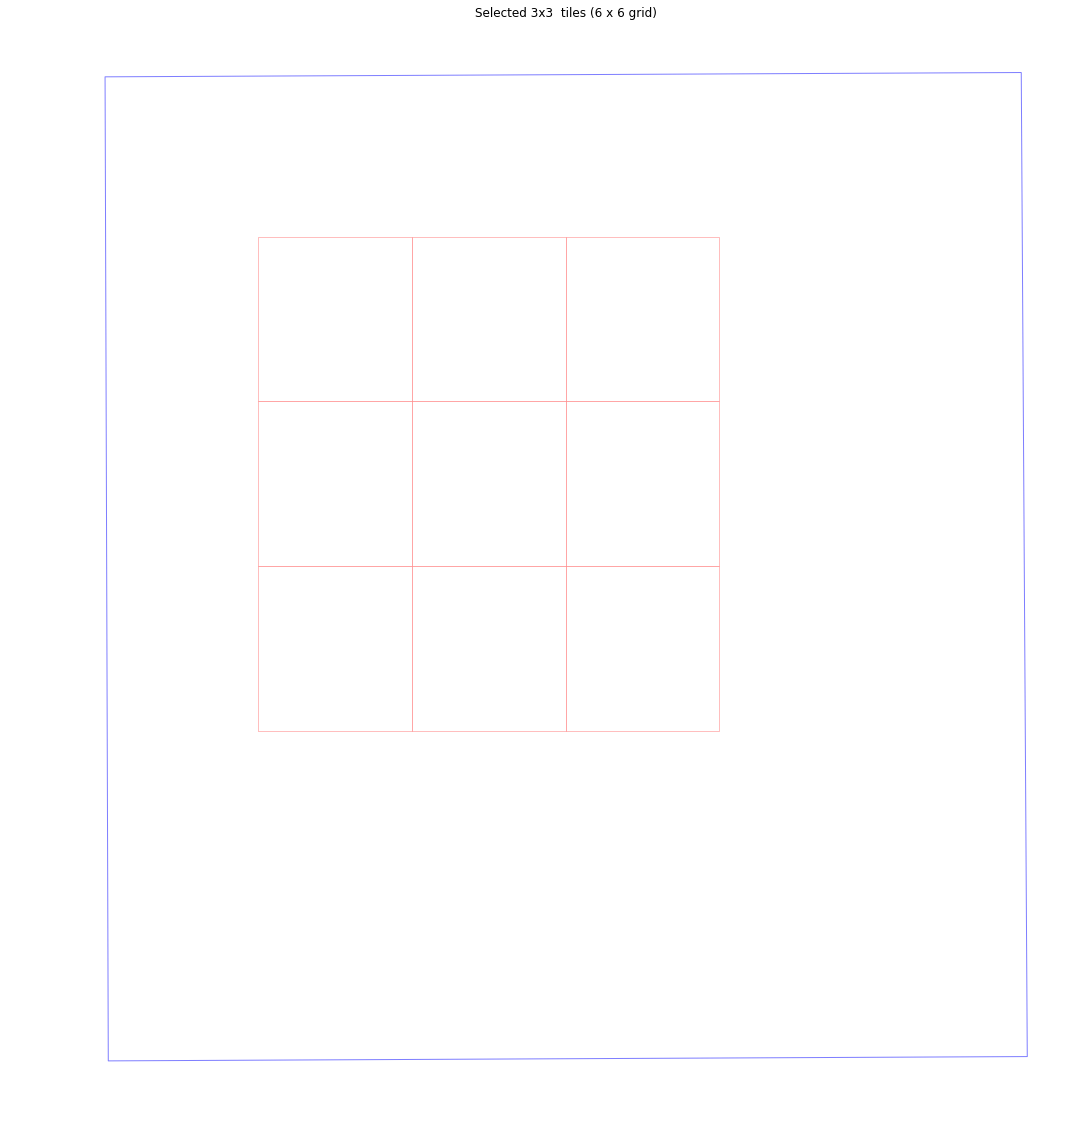

In [6]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles (6 x 6 grid)');
plt.axis('off')

In [7]:
# часть 4. Описание задач рабочего процесса

class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch

class EuclideanNorm(EOTask):
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name

    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))

        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch    
    
    
class NormalBurningRatio(EOTask):
    """
    NBR = (9 - 12)/(9 + 12)
    DNBR = NBR_2 - NBR_1
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        nbr = (band_a - band_b)/(band_a + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, nbr[..., np.newaxis])

        return eopatch    

In [8]:
# Определение задач рабочего процесса
# TASK FOR BAND DATA

# add a request for R(B04), NIR (B08), Vegetation Red Edge VRE(B8A), Water vapour WV(B9), SWIR1(B11), SWIR2(B12)

# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
custom_script = 'return [B04, B08, B08A, B09, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NBR = (9 - 12)/(9 + 12)

nbr = NormalBurningRatio('NBR', 'BANDS/3','BANDS/5')
norm = EuclideanNorm('NORM','BANDS')


# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

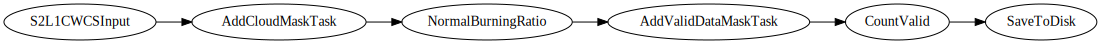

In [9]:
workflow = LinearWorkflow(
    add_data,
    add_clm,
    nbr,
    add_sh_valmask,
    count_val_sh,     # add rasterisation task, if you want to use land_cover_map
    save
)

# Let's visualize it
workflow.dependency_graph()

In [10]:
%%time

# Execute the workflow
time_interval = first_time_interval # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()


Wall time: 16.2 s


In [11]:
EOPatch.load('./eopatches_small/eopatch_0/')

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(1, 257, 240, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(1, 257, 240, 1), dtype=float32)
    NBR: numpy.ndarray(shape=(1, 257, 240, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(1, 257, 240, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(1, 257, 240, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(1, 257, 240, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    VALID_COUNT: numpy.ndarray(shape=(257, 240, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ['2019-04-18', '2019-04-20']
  }
  bbox: BBox(((518913.6757253294, 5727228.931828612), (521315.3085657184, 5729802.826976469)), crs=EPSG:32635)
  timestamp: [datetime.datetime(2019, 4, 19, 9, 34, 38)]
)

In [12]:
# use more them 1 data for mean calculation indicie

# eID = 1
# eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, eID), lazy_loading=True)

# nbr = eopatch.data['NBR'] # nbr data cube
# mask = eopatch.mask['IS_VALID'] # mask of valid pixels
# time = np.array(eopatch.timestamp) # x axis
# t, w, h, _ = nbr.shape

# nbr_clean = nbr.copy()
# nbr_clean[~mask] = np.nan # set values of invalid pixels to NaN's

# # Calculate means, remove NaN's from means
# nbr_mean = np.nanmean(nbr.reshape(t, w * h).squeeze(), axis=1)
# nbr_mean_clean = np.nanmean(nbr_clean.reshape(t, w * h).squeeze(), axis=1)
# time_clean = time[~np.isnan(nbr_mean_clean)]
# nbr_mean_clean = nbr_mean_clean[~np.isnan(nbr_mean_clean)]

# fig = plt.figure(figsize=(20,5))
# plt.plot(time_clean, nbr_mean_clean, 's-', label = 'Mean NBR with cloud cleaning')
# plt.plot(time, nbr_mean, 'o-', label='Mean NBR without cloud cleaning')
# plt.xlabel('Time', fontsize=15)
# plt.ylabel('Mean NBR over patch', fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# plt.legend(loc=2, prop={'size': 15});

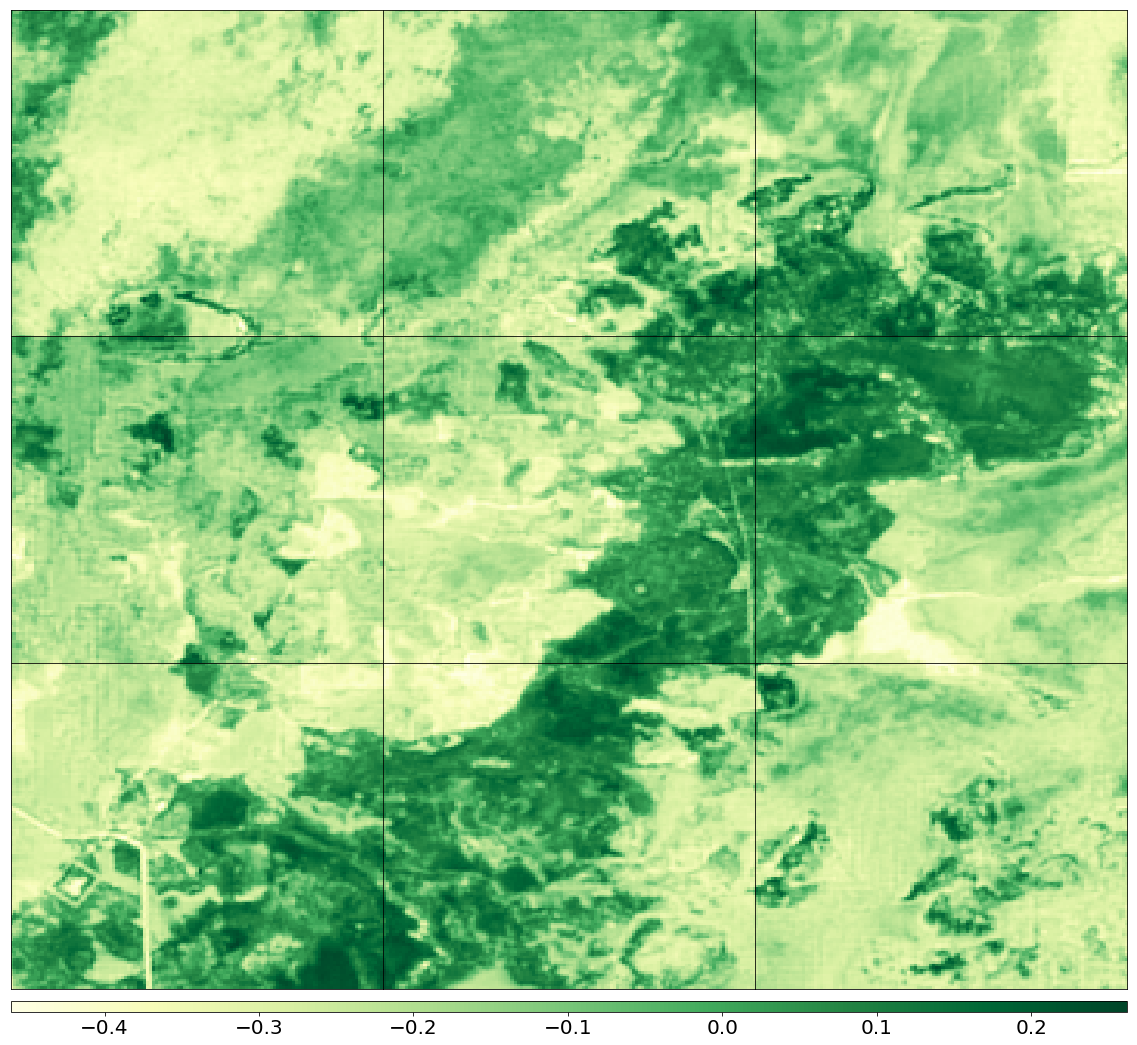

In [13]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    nbr = eopatch.data['NBR']
    mask = eopatch.mask['IS_VALID']
    nbr[~mask] = np.nan
    nbr_mean = np.nanmean(nbr, axis=0).squeeze()
    im = ax.imshow(nbr_mean, vmin=np.amin(nbr_mean), vmax=np.amax(nbr_mean),cmap=plt.get_cmap('YlGn'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

In [14]:
# next nbr calculation

In [15]:
# post-fire data acquisition
add_data_double = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS_D'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm_double= AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

nbr_double = NormalBurningRatio('NBR_D', 'BANDS_D/3','BANDS_D/5')
norm_double = EuclideanNorm('NORM_D','BANDS_D')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

path_out_double = './eopatches_small_double/' if use_smaller_patches else './eopatches_large_double/'
if not os.path.isdir(path_out_double):
    os.makedirs(path_out_double)
save_double = SaveToDisk(path_out_double, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

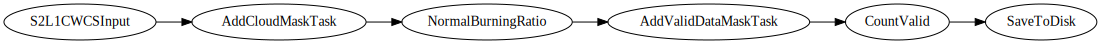

In [16]:
workflow_double = LinearWorkflow(
    add_data_double, 
    add_clm_double,
    nbr_double,
    add_sh_valmask,
    count_val_sh,     # add rasterisation task, if you want to use land_cover_map
    save_double
)

# Let's visualize it
workflow_double.dependency_graph()

In [17]:
%%time

# Execute the workflow
time_interval = last_time_interval # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data_double:{'bbox': bbox, 'time_interval': time_interval},
        save_double: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })

executor = EOExecutor(workflow_double, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()

Wall time: 16.9 s


In [18]:
EOPatch.load('./eopatches_small_double/eopatch_0/')

EOPatch(
  data: {
    BANDS_D: numpy.ndarray(shape=(1, 257, 240, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(1, 257, 240, 1), dtype=float32)
    NBR_D: numpy.ndarray(shape=(1, 257, 240, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(1, 257, 240, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(1, 257, 240, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(1, 257, 240, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    VALID_COUNT: numpy.ndarray(shape=(257, 240, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ['2019-08-21', '2019-08-22']
  }
  bbox: BBox(((518913.6757253294, 5727228.931828612), (521315.3085657184, 5729802.826976469)), crs=EPSG:32635)
  timestamp: [datetime.datetime(2019, 8, 22, 9, 26, 4)]
)

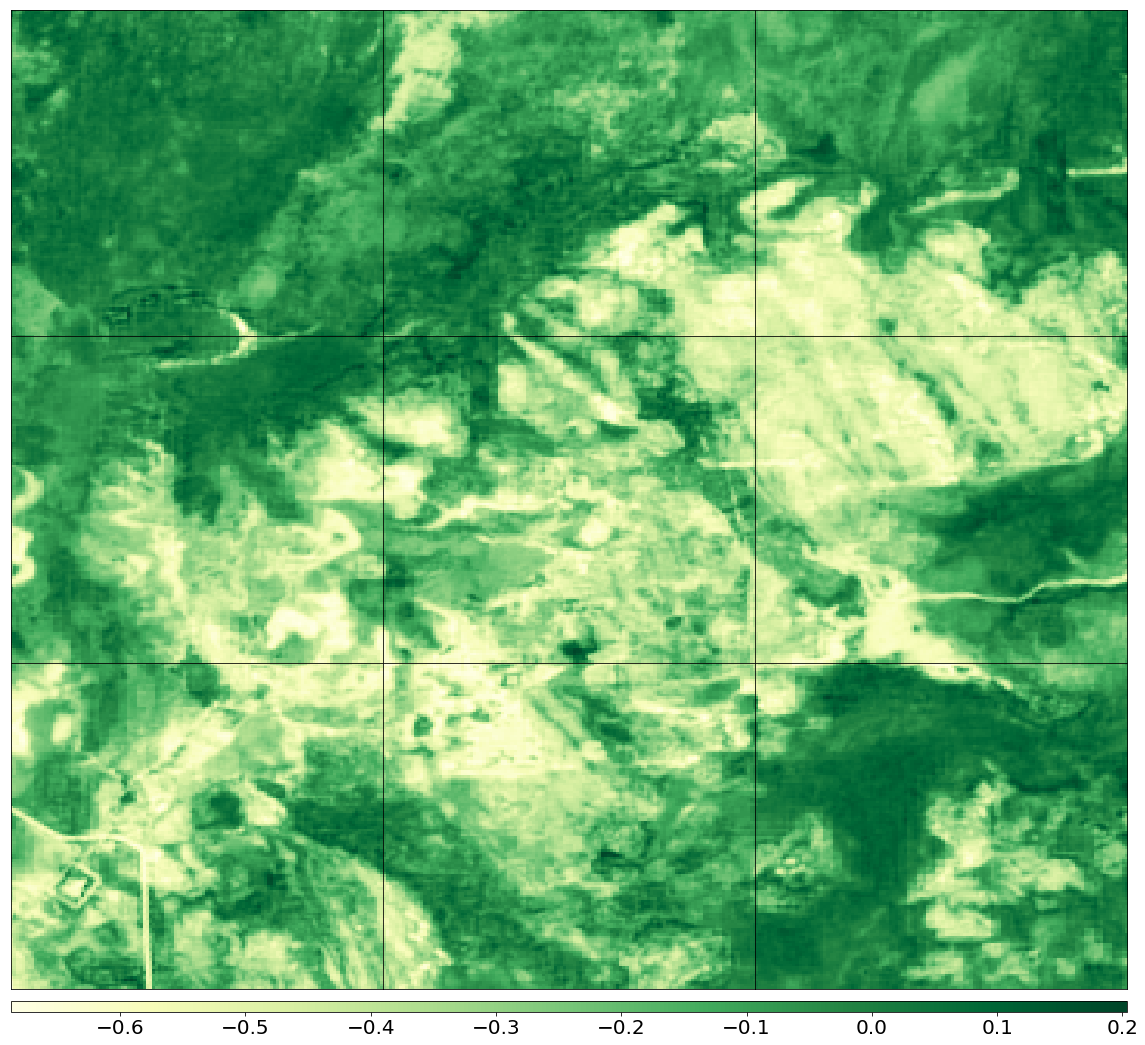

In [19]:
path_out = './eopatches_small_double/' if use_smaller_patches else './eopatches_large_double/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    nbr = eopatch.data['NBR_D']
    mask = eopatch.mask['IS_VALID']
    nbr[~mask] = np.nan
    nbr_mean = np.nanmean(nbr, axis=0).squeeze()
    im = ax.imshow(nbr_mean, vmin=np.amin(nbr_mean), vmax=np.amax(nbr_mean),cmap=plt.get_cmap('YlGn'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

In [20]:
patch1 = EOPatch.load('./eopatches_small/eopatch_0/')
patch2 = EOPatch.load('./eopatches_small_double/eopatch_0/')

patch1_clean = patch1.__deepcopy__()
patch2_clean = patch2.__deepcopy__()

list_item = ['maxcc', 'service_type', 'size_x', 'size_y', 'time_difference', 'time_interval']
for i in list_item:
    del patch1_clean.meta_info[i]
    
#del patch1_clean.timestamp[datetime]
patch = patch1_clean + patch2_clean


In [21]:
patch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(1, 257, 240, 6), dtype=float32)
    BANDS_D: numpy.ndarray(shape=(1, 257, 240, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(2, 257, 240, 1), dtype=float32)
    NBR: numpy.ndarray(shape=(1, 257, 240, 1), dtype=float32)
    NBR_D: numpy.ndarray(shape=(1, 257, 240, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(2, 257, 240, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(2, 257, 240, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(2, 257, 240, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    VALID_COUNT: numpy.ndarray(shape=(257, 240, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ['2019-08-21', '2019-08-22']
  }
  bbox: BBox(((518913.6757253294, 5727228.

In [40]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk('./eopatches_small/')

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.DATA, 'NBR'))
tiff_location = './predicted_tiff'
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

workflow_export = LinearWorkflow(
    load,
    export_tiff
)

execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            load: {'eopatch_folder': 'eopatch_{}'.format(i)},
            export_tiff: {'filename': '{}/prediction_eopatch_{}.tiff'.format(tiff_location, i)}
        }
    )

In [39]:
# run the executor on 2 cores
executor = EOExecutor(workflow_export, execution_args)

executor.run(workers=5, multiprocess=False)

executor.make_report()

In [43]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk('./eopatches_small_double/')

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.DATA, 'NBR_D'))
tiff_location = './predicted_tiff_D'
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)

workflow_export_D = LinearWorkflow(
    load,
    export_tiff
)

execution_args = []
for i in range(len(patchIDs)):
    execution_args.append(
        {
            load: {'eopatch_folder': 'eopatch_{}'.format(i)},
            export_tiff: {'filename': '{}/prediction_eopatch_D{}.tiff'.format(tiff_location, i)}
        }
    )

In [44]:
# run the executor on 2 cores
executor = EOExecutor(workflow_export_D, execution_args)

executor.run(workers=5, multiprocess=False)

executor.make_report()